<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/MVTec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

In [88]:
img_height = 224
img_width = 224

base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [89]:
num_classes = 30

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x=Dense(512,activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = preds)

In [0]:
base_model.trainable = False

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [0]:
bs = 16
CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet','defective_grid',
           'defective_hazelnut','defective_leather','defective_metalnut','defective_pill','defective_screw',
           'defective_tile','defective_toothbrush','defective_transistor','defective_wood','defective_zipper',
           'good_bottle','good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill','good_screw',
           'good_tile','good_toothbrush','good_transistor','good_wood','good_zipper']

In [93]:
train_generator=train_datagen.flow_from_directory('train',  
                                                 target_size=(224,224),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                 classes=CLASSES)

Found 2884 images belonging to 30 classes.


In [94]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

Label map:  {'defective_bottle': 0, 'defective_cable': 1, 'defective_capsule': 2, 'defective_carpet': 3, 'defective_grid': 4, 'defective_hazelnut': 5, 'defective_leather': 6, 'defective_metalnut': 7, 'defective_pill': 8, 'defective_screw': 9, 'defective_tile': 10, 'defective_toothbrush': 11, 'defective_transistor': 12, 'defective_wood': 13, 'defective_zipper': 14, 'good_bottle': 15, 'good_cable': 16, 'good_capsule': 17, 'good_carpet': 18, 'good_grid': 19, 'good_hazelnut': 20, 'good_leather': 21, 'good_metalnut': 22, 'good_pill': 23, 'good_screw': 24, 'good_tile': 25, 'good_toothbrush': 26, 'good_transistor': 27, 'good_wood': 28, 'good_zipper': 29}


In [95]:
unique, counts = np.unique(train_generator.labels, return_counts=True)
print(counts)

[ 36  52  61  50  26  40  52  52  80  33  48  17  23  34  67 128 158 136
 173 160 242 110 136 164 203 142   7 153 149 152]


In [96]:
val_generator=train_datagen.flow_from_directory('train', 
                                                 target_size=(224,224),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 704 images belonging to 30 classes.


In [0]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['acc'])

In [98]:
step_size_train = train_generator.n//train_generator.batch_size
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  180
Validation step size:  45


In [0]:
initial_epochs = 25

In [100]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

Epoch 1/25
180/180 [==============================] - 1440s 8s/step - loss: 1.2533 - acc: 0.6576 - val_loss: 0.8913 - val_acc: 0.8000
Epoch 2/25
180/180 [==============================] - 182s 1s/step - loss: 0.6927 - acc: 0.7653 - val_loss: 0.6377 - val_acc: 0.7625
Epoch 3/25
180/180 [==============================] - 173s 960ms/step - loss: 0.5566 - acc: 0.8083 - val_loss: 0.5193 - val_acc: 0.7917
Epoch 4/25
180/180 [==============================] - 168s 935ms/step - loss: 0.5430 - acc: 0.8083 - val_loss: 0.5144 - val_acc: 0.7833
Epoch 5/25
180/180 [==============================] - 170s 945ms/step - loss: 0.4427 - acc: 0.8319 - val_loss: 0.3839 - val_acc: 0.8750
Epoch 6/25
180/180 [==============================] - 168s 931ms/step - loss: 0.3725 - acc: 0.8719 - val_loss: 0.4388 - val_acc: 0.8653
Epoch 7/25
180/180 [==============================] - 166s 924ms/step - loss: 0.3813 - acc: 0.8643 - val_loss: 0.3879 - val_acc: 0.8694
Epoch 8/25
180/180 [==============================] -

In [101]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

45/45 [==============================] - 34s 752ms/step
Validating loss: 0.6848793807284286
Validating accuracy: 0.8458333333333333


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

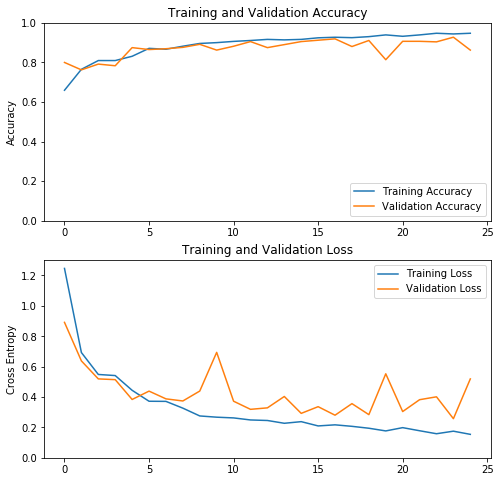

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_epoch25_2.jpg')
plt.show()

In [39]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=a6d75733d5200b99d11ebb3da169b7d4dde4e506dd69abc7c4975b732dfc1345
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 10.6 GB  | Proc size: 4.1 GB
GPU RAM Free: 7539MB | Used: 8741MB | Util  54% | Total 16280MB


In [0]:
# !kill -9 -1

In [0]:
# model.save('/content/drive/My Drive/xai_model/MVTec_25_2.h5')
# model.save_weights('/content/drive/My Drive/xai_model/MVTec_25_weights_2.h5')

In [38]:
# model = load_model('/content/drive/My Drive/xai_model/MVTec_25_2.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [116]:
bs_test = 8
test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(224,224),     
                                                  batch_size=bs_test,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 1542 images belonging to 30 classes.


In [120]:
step_size_test = (test_generator.n//test_generator.batch_size)+1
print(step_size_test)
test_generator.reset()

193


In [121]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

193/193 [==============================] - 74s 386ms/step


In [122]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print(acc_o)

0.8728923476005188


In [123]:
print(len(predIndxs))
print(len(test_generator.labels))

1542
1542


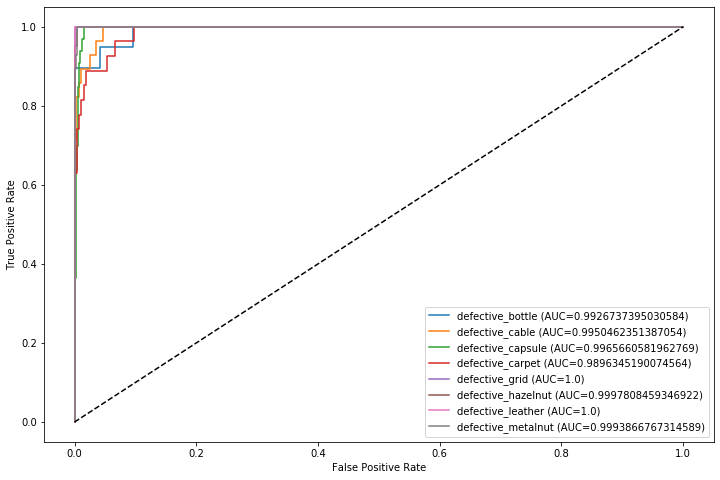

In [134]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[:8]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

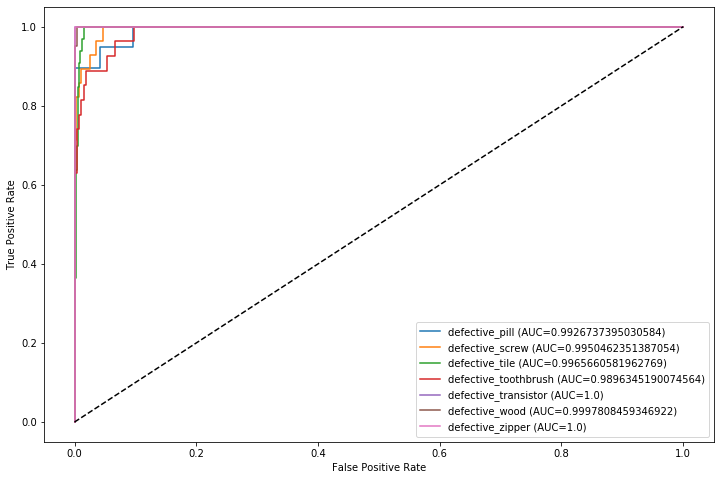

In [135]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[8:15]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

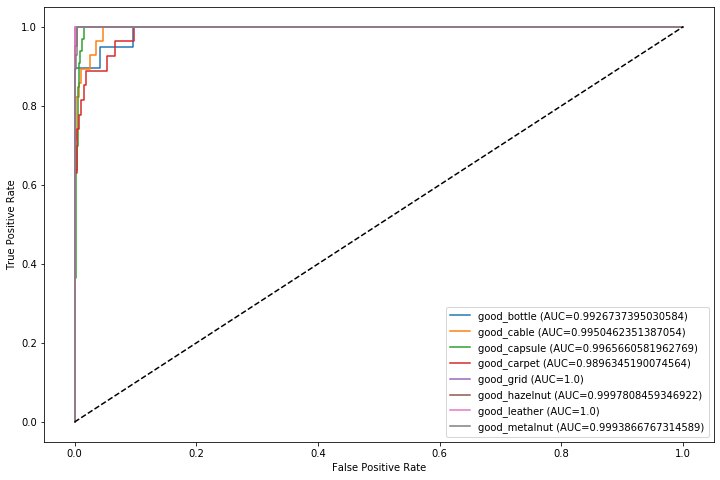

In [136]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[15:23]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

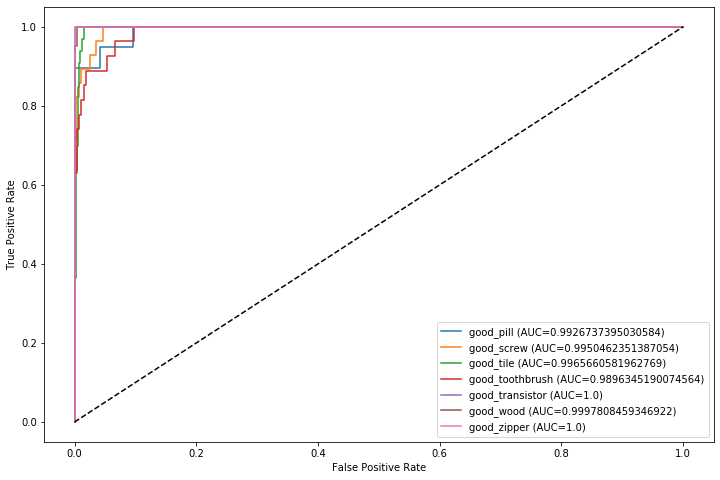

In [137]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[23:30]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

In [138]:
predIndxs_max = np.argmax(predIndxs, axis=1)
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

    defective_bottle       1.00      0.84      0.91        19
     defective_cable       0.40      0.89      0.56        28
   defective_capsule       0.83      0.58      0.68        33
    defective_carpet       0.84      0.59      0.70        27
      defective_grid       1.00      0.93      0.96        14
  defective_hazelnut       1.00      0.90      0.95        21
   defective_leather       1.00      1.00      1.00        28
  defective_metalnut       0.72      1.00      0.84        28
      defective_pill       0.38      1.00      0.55        42
     defective_screw       0.00      0.00      0.00        17
      defective_tile       1.00      0.72      0.84        25
defective_toothbrush       1.00      0.78      0.88         9
defective_transistor       1.00      0.42      0.59        12
      defective_wood       0.88      0.83      0.86        18
    defective_zipper       0.97      0.83      0.90        36
       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5] + cm[6, 6] +
       cm[7, 7] + cm[8, 8] + cm[9, 9] + cm[10, 10] + cm[11, 11] + cm[12, 12] +
       cm[13, 13] + cm[14, 14] + cm[15, 15] + cm[16, 16] + cm[17, 17] + cm[18, 18] +
       cm[19, 19] + cm[20, 20] + cm[21, 21] + cm[22, 22] + cm[23, 23] + cm[24, 24] +
       cm[25, 25] + cm[26, 26] + cm[27, 27] + cm[28, 28] + cm[29, 29]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[ 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  19   0   0   0   0   0   0   0   0   0   0   0   0   0   0  14
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   11   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  13   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0  19   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  28   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  28   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0

In [0]:
# normalized_cm = cm/total
# print('Normalized Confusion matrix:')
# print(normalized_cm)

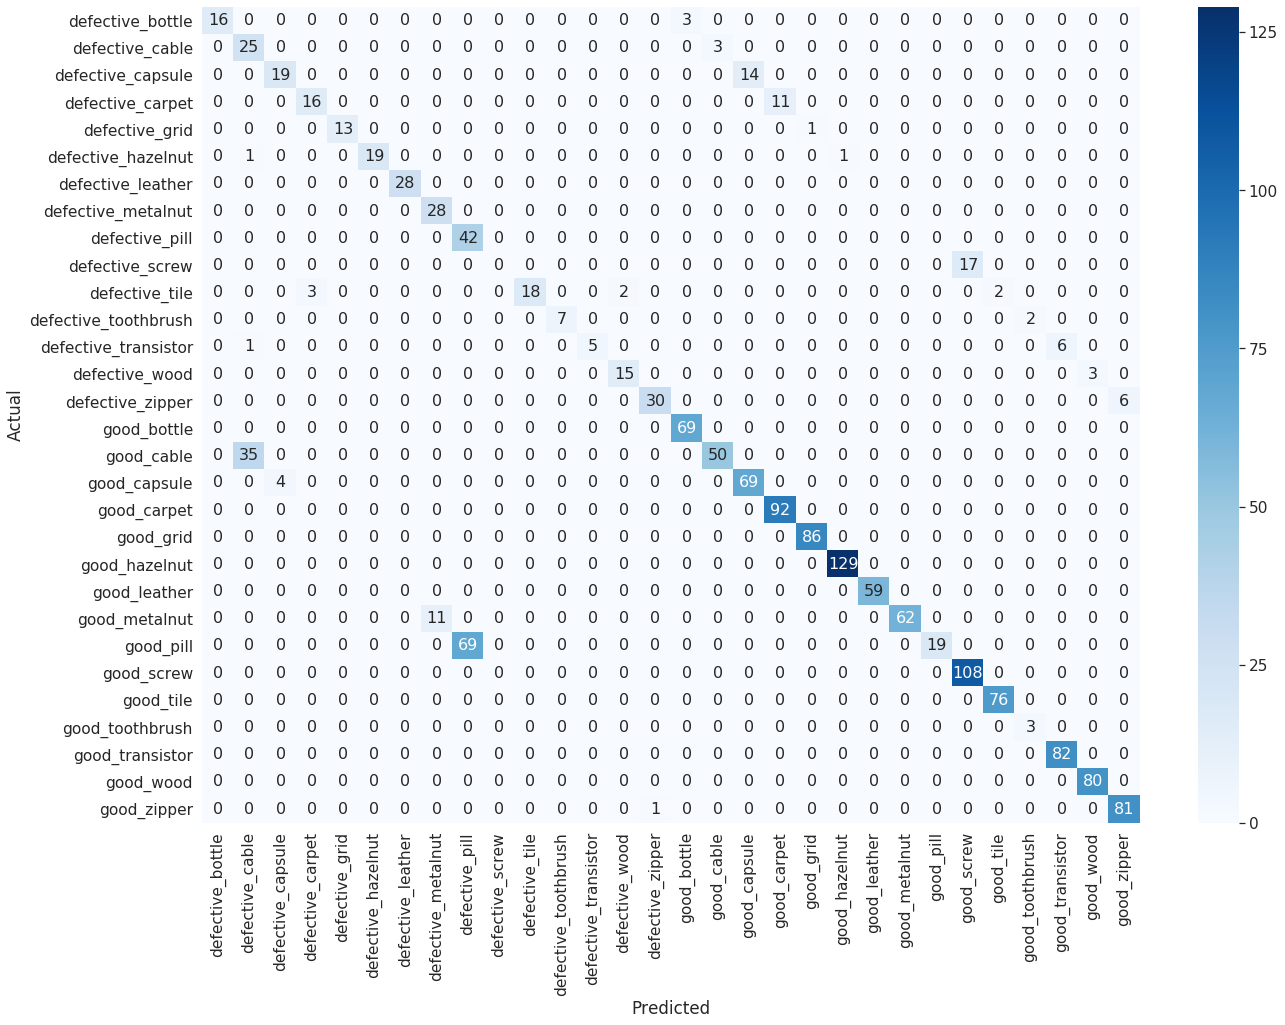

In [145]:
import seaborn as sn
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_25_CM_2.jpg')

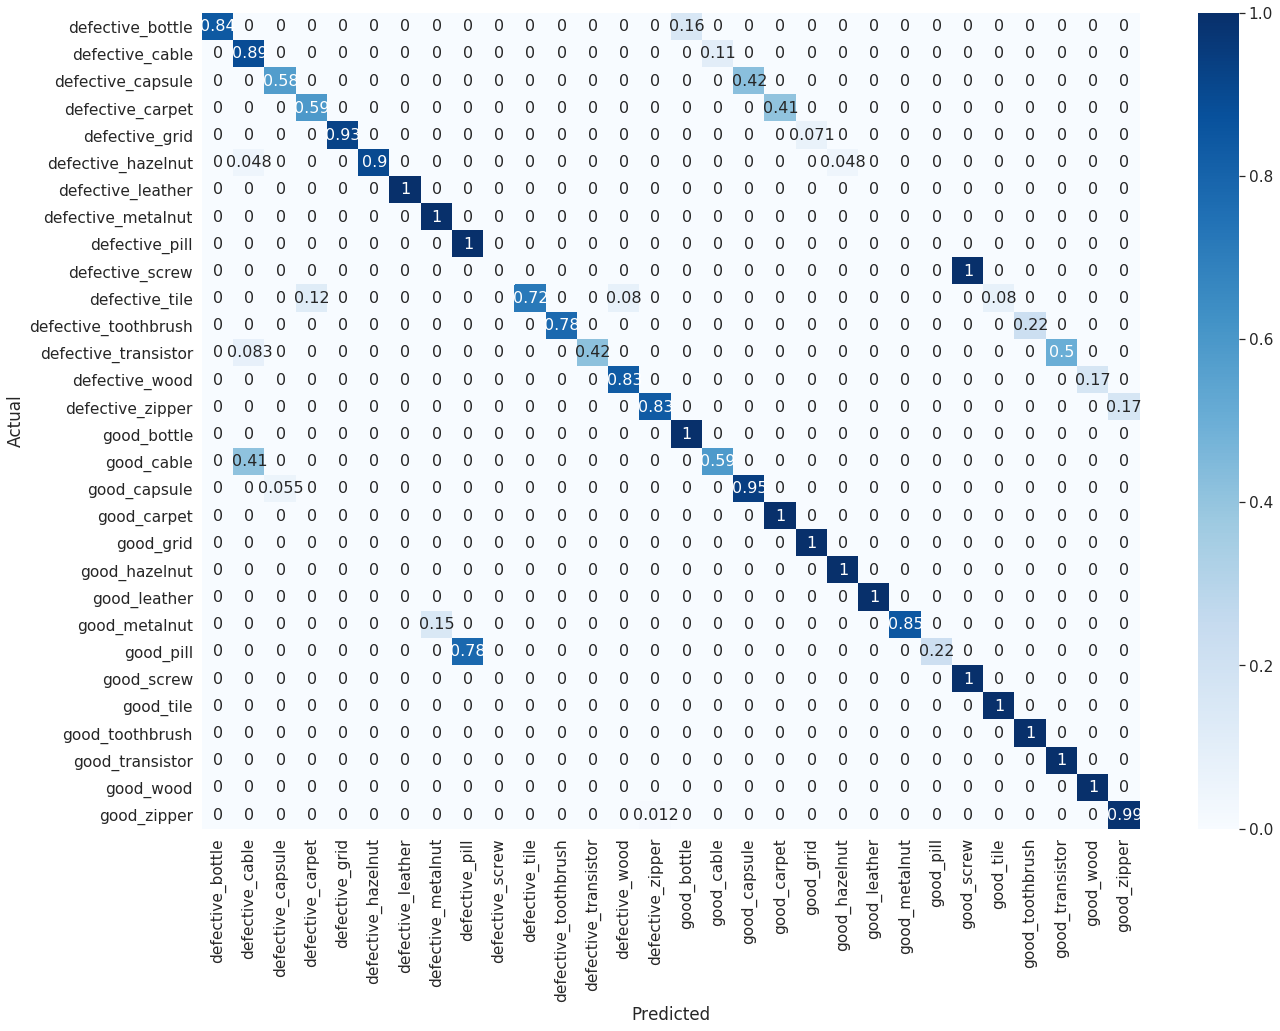

In [146]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_25_CM_N_2.jpg')

# Prediction

In [0]:
image_path = "/content/drive/My Drive/data/test/defective_screw/screw_scratch_head_001.png"

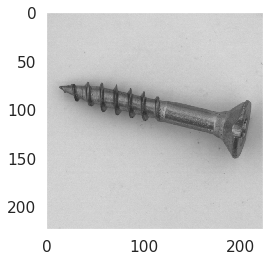

In [159]:
test_img = image.load_img(image_path, target_size=(224,224,3))
plt.grid(None)
plt.imshow(test_img)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [160]:
label_map_inv = {v:k  for k,v in label_map.items()}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

[[5.79698756e-03 5.05916891e-04 2.71463627e-03 2.03147560e-04
  2.71463767e-04 6.37663106e-05 3.89089982e-05 2.45294097e-04
  8.39525164e-05 1.57114401e-01 1.74542074e-04 1.54910551e-04
  2.97390070e-04 6.09335730e-05 1.26198365e-05 3.76763746e-05
  5.19436617e-06 1.08318083e-04 8.88852628e-06 1.53937308e-05
  3.55235352e-05 6.52169729e-06 2.40422032e-05 4.64173309e-06
  8.31885338e-01 2.53384587e-06 4.09778795e-06 9.08572838e-05
  6.35987135e-06 2.55866671e-05]]
[24]
Output :  good_screw


In [162]:
unique, counts_train = np.unique(train_generator.labels, return_counts=True)
print("Images per class in Training step: ",counts_train)
unique, counts_val = np.unique(val_generator.labels, return_counts=True)
print("\n Images per class in Validation step: ",counts_val)
unique, counts_test = np.unique(test_generator.labels, return_counts=True)
print("\n Images per class in Testing step : ",counts_test)

Images per class in Training step:  [ 36  52  61  50  26  40  52  52  80  33  48  17  23  34  67 128 158 136
 173 160 242 110 136 164 203 142   7 153 149 152]

 Images per class in Validation step:  [ 8 12 15 12  6  9 12 13 19  8 11  4  5  8 16 32 39 33 43 39 60 27 33 41
 50 35  1 38 37 38]

 Images per class in Testing step :  [ 19  28  33  27  14  21  28  28  42  17  25   9  12  18  36  69  85  73
  92  86 129  59  73  88 108  76   3  82  80  82]


In [0]:
# N = 30
# ind = np.arange(N)
# width = 0.5       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, counts_train, width)
# p2 = plt.bar(ind, counts_val, width)
# p3 = plt.bar(ind, counts_test, width)

# # plt.ylabel('Scores')
# # plt.title('Scores by group and gender')
# # plt.xticks(ind, list(test_generator.class_indices.keys())[:5])
# # plt.yticks(np.arange(0, 81, 10))
# # plt.legend((p1[0], p2[0]), ('Men', 'Women'))
# # plt.figure(figsize = (21,15))
# # plt.grid(None)
# # plt.show()

# plt.grid(None)
# fig = plt.gcf()
# fig.set_size_inches(15, 8)

In [243]:
import plotly.graph_objects as go

headerColor = 'grey'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Class Labels</b>','<b>Training</b>','<b>Validation</b>','<b>Test</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      list(label_map.keys()),
      counts_train,
      counts_val,
      counts_test],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    # fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*30],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.update_layout(
    autosize=False,
    width=700,
    height=825,
    title_text = "Dataset distribution table"
)

fig.show()